In [1]:
import sys
sys.path.append('./utils')
from utils_imports import *

In [2]:
with open("models/best_gp.pkl", "rb") as file:
    gpr = pickle.load(file)

/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.4.1.post1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.4.1.post1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
gpr.regressor_.L_ = None

In [4]:
with open("models/kernel.pkl", "wb") as file:
    pickle.dump(gpr, file)

In [5]:
with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)

In [6]:
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

fmin_l_bfgs_b
None


In [7]:
points = get_points("dump.sqlite")
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

((19031, 2), (19031,))

In [8]:
gpr = fit_gpr_silent(gpr, X, y)

No optimization done.
Optimization time:  64.78560256958008
Kernel calc time:  21.230030059814453
Cholesky time:  43.38096022605896
Alpha time:  0.24601435661315918


No optimization done.
Optimization time:  57.39972186088562
Kernel calc time:  17.13384437561035
Cholesky time:  39.87054944038391
Alpha time:  0.25893354415893555
Compute rows of pixels...


  0%|          | 0/360 [00:00<?, ?it/s]

Time elapsed to compute full map: 793.9036958217621
For map of shape: (360, 136) that is 48960 pixels and a time per pixel of 0.016215353931476866 seconds
Loading country shapes...
Time elapsed to load countries: 0.1521596908569336
Transforming heatmap...
max map waiting time: 359.7774545091566
min map waiting time: 1.2772924946865343
Time elapsed to transform heatmap: 0.09166765213012695
Plotting heatmap...
Time elapsed to load uncertainties: 0.00091552734375


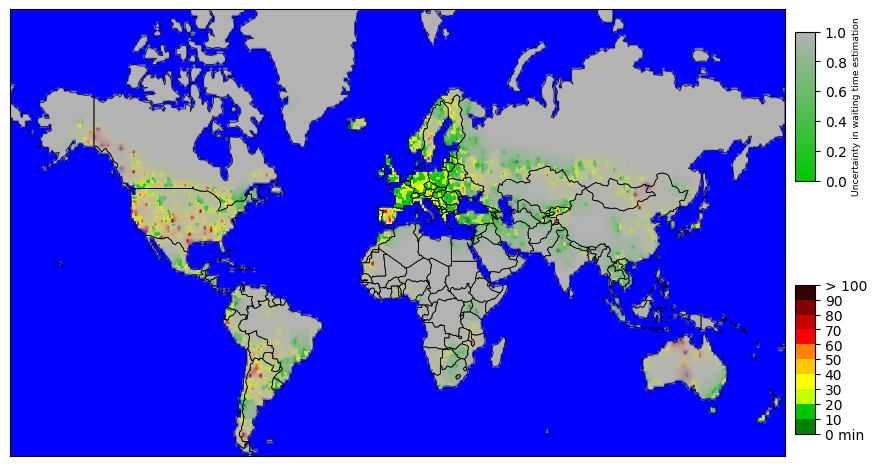

In [ ]:
map_from_model(gpr, region='world', show_uncertainties=True, verbose=True, resolution=1)

In [9]:
raster_maker = raster_from_model(
    gpr,
    "world",
    1,
    show_uncertainties=True,
    verbose=True,
)

Compute rows of pixels...


  0%|          | 0/360 [00:00<?, ?it/s]

Time elapsed to compute full map: 777.7028756141663
For map of shape: (360, 136) that is 48960 pixels and a time per pixel of 0.015884454835668887 seconds


In [363]:
map_path = raster_maker.get_raster_path()
map_path

'intermediate/map_TransformedTargetRegressorWithUncertainty_world_1.tif'

In [364]:
countries = gpd.read_file(
    "map_features/countries/ne_110m_admin_0_countries.shp"
)
countries = countries.to_crs(epsg=3857)
countries = countries[countries.NAME != "Antarctica"]
country_shapes = countries.geometry
country_shapes = country_shapes.apply(lambda x: make_valid(x))

In [365]:
nodata = np.nan
with rasterio.open(map_path) as heatmap:
    start = time.time()
    max_map_wait = heatmap.read().max()
    min_map_wait = heatmap.read().min()
    if raster_maker.verbose:
        print("max map waiting time:", max_map_wait)
    if raster_maker.verbose:
        print("min map waiting time:", min_map_wait)

    out_image, out_transform = rasterio.mask.mask(
        heatmap, country_shapes, nodata=nodata
    )
    out_meta = heatmap.meta
    print(f"Time elapsed to transform heatmap: {time.time() - start}")

out_meta.update(
    {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    }
)

new_map_path = f"intermediate/map_{raster_maker.method}_{raster_maker.region}_{raster_maker.resolution}_processed.tif"
with rasterio.open(new_map_path, "w", **out_meta) as destination:
    destination.write(out_image)

raster = rasterio.open(new_map_path)

max map waiting time: 359.7774545091566
min map waiting time: 1.2772924946865343
Time elapsed to transform heatmap: 0.056611061096191406


In [366]:
Z = raster.read()[0]
Z.shape

(136, 360)

In [367]:
import xyzservices.providers as xyz
import folium
lon, lat = 12, 48.875
zoom_start = 2


tiles = xyz.CartoDB.Positron
m = folium.Map(
    tiles=folium.TileLayer(no_wrap=True, tiles=tiles),
    attr="Dummy",
    zoom_start=zoom_start,
    location=[lat, lon],
)

In [368]:
BUCKETS = [
    "#008200",  # dark green
    "#00c800",  # light green
    "#c8ff00",  # light yellow
    "#ffff00",  # yellow
    "#ffc800",  # light orange
    "#ff8200",  # dark orange
    "red",  # red
    "#c80000",  # dark red
    "#820000",  # wine red
    "#330100",  # drop?
]

# define the heatmap color scale
# values higher than the upper boundary are colored in the upmost color
BOUNDARIES = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

import matplotlib.colors as colors
cmap = colors.ListedColormap(BUCKETS)

norm = colors.BoundaryNorm(BOUNDARIES, cmap.N, clip=True)
cmap.set_bad(color="#000000", alpha=0.0) # opaque for NaN values (sea)

In [369]:
image = norm(Z).data
image.shape, np.unique(image, return_counts=True)

((136, 360),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16),
  array([  251,  4382,  9815,  1039,   418,   226,   113,    35,    30,
            58, 32593])))

In [370]:
uncertainties = raster_maker.raw_uncertainties
uncertainties.shape

(136, 360)

In [371]:
discrete_uncertainties = False
uncertainties = np.where(
    np.isnan(raster.read()[0]), uncertainties.min(), uncertainties
)
if (uncertainties.max() - uncertainties.min()) != 0:
    uncertainties = (uncertainties - uncertainties.min()) / (
        uncertainties.max() - uncertainties.min()
    )
    uncertainties = 1 - uncertainties
    if discrete_uncertainties:
        # threshold for uncertainty decided by experiment
        uncertainties = np.where(uncertainties < 0.25, 0.0, 1.0)
else:
    uncertainties = 1.0
# let uncertainty be high in the sea
uncertainties = np.where(np.isnan(raster.read()[0]), 0.0, uncertainties)
uncertainties = uncertainties.astype(
    np.float64
)  # matplotlib cannot handle float128
raster_maker.uncertainties = uncertainties

In [372]:
import numpy as np
import matplotlib.pyplot as plt

# Input 2D scalar array
scalars = image
opacities = uncertainties

# Apply the colormap to scalars
colors = cmap(scalars)

# Combine RGB values with the opacity
rgba_array = np.empty_like(colors)
rgba_array[:, :, :3] = colors[:, :, :3]  # RGB
rgba_array[:, :, 3] = opacities  # A

# Verify shape and content
print(rgba_array.shape)

(136, 360, 4)


In [373]:
np.unique(scalars, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16),
 array([  251,  4382,  9815,  1039,   418,   226,   113,    35,    30,
           58, 32593]))

In [374]:
cmap(10)

(0.2, 0.00392156862745098, 0.0, 1.0)

In [375]:
folium.raster_layers.ImageOverlay(
    image=rgba_array,
    bounds=[[-56, -180], [80, 180]],
).add_to(m)

/home/till/.local/lib/python3.10/site-packages/branca/utilities.py:329: RuntimeWarning: invalid value encountered in divide
  array = array * 255./array.max(axis=(0, 1)).reshape((1, 1, 4))
/home/till/.local/lib/python3.10/site-packages/branca/utilities.py:330: RuntimeWarning: invalid value encountered in cast
  array = array.astype('uint8')



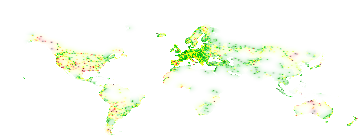

In [376]:
m